In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.initializers import RandomUniform
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scipy.stats import norm
import matplotlib.pyplot as plt

### Helper functions

In [2]:

def stock_price_simulator(S0, mu, sigma, T, N, M):
    """
    Simulates stock price paths using Geometric Brownian Motion (GBM).
    """
    dt = T / N
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for i in range(1, N + 1):
        S[:, i] = S[:, i - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, M)
        )
    return S

def bs_option_price(S, K, T, r, sigma, option_type="call", epsilon=1e-10):
    """
    Computes the Black-Scholes price of an option. Handles both scalar and array inputs.
    """
    # Ensure inputs are arrays for vectorized operations
    S = np.array(S, dtype=np.float64)
    K = np.array(K, dtype=np.float64)
    T = np.array(T, dtype=np.float64)
    sigma = np.array(sigma, dtype=np.float64)

    # Add a small constant epsilon to avoid invalid values
    T = np.maximum(T, epsilon)
    sigma = np.maximum(sigma, epsilon)
    S = np.maximum(S, epsilon)
    K = np.maximum(K, epsilon)
    
    # Compute d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Option pricing formulas
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price

def payoff_fun(S, K, option_type):
    """
    Computes the option payoff.
    """
    if option_type == "put":
        return np.maximum(K - S, 0)
    else:
        return np.maximum(S - K, 0)

def create_shallow_NN(input_dim, no_hidden_units):
    """
    Creates a shallow neural network model.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(no_hidden_units, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return model


### Binomial & RLLN Static Hedging

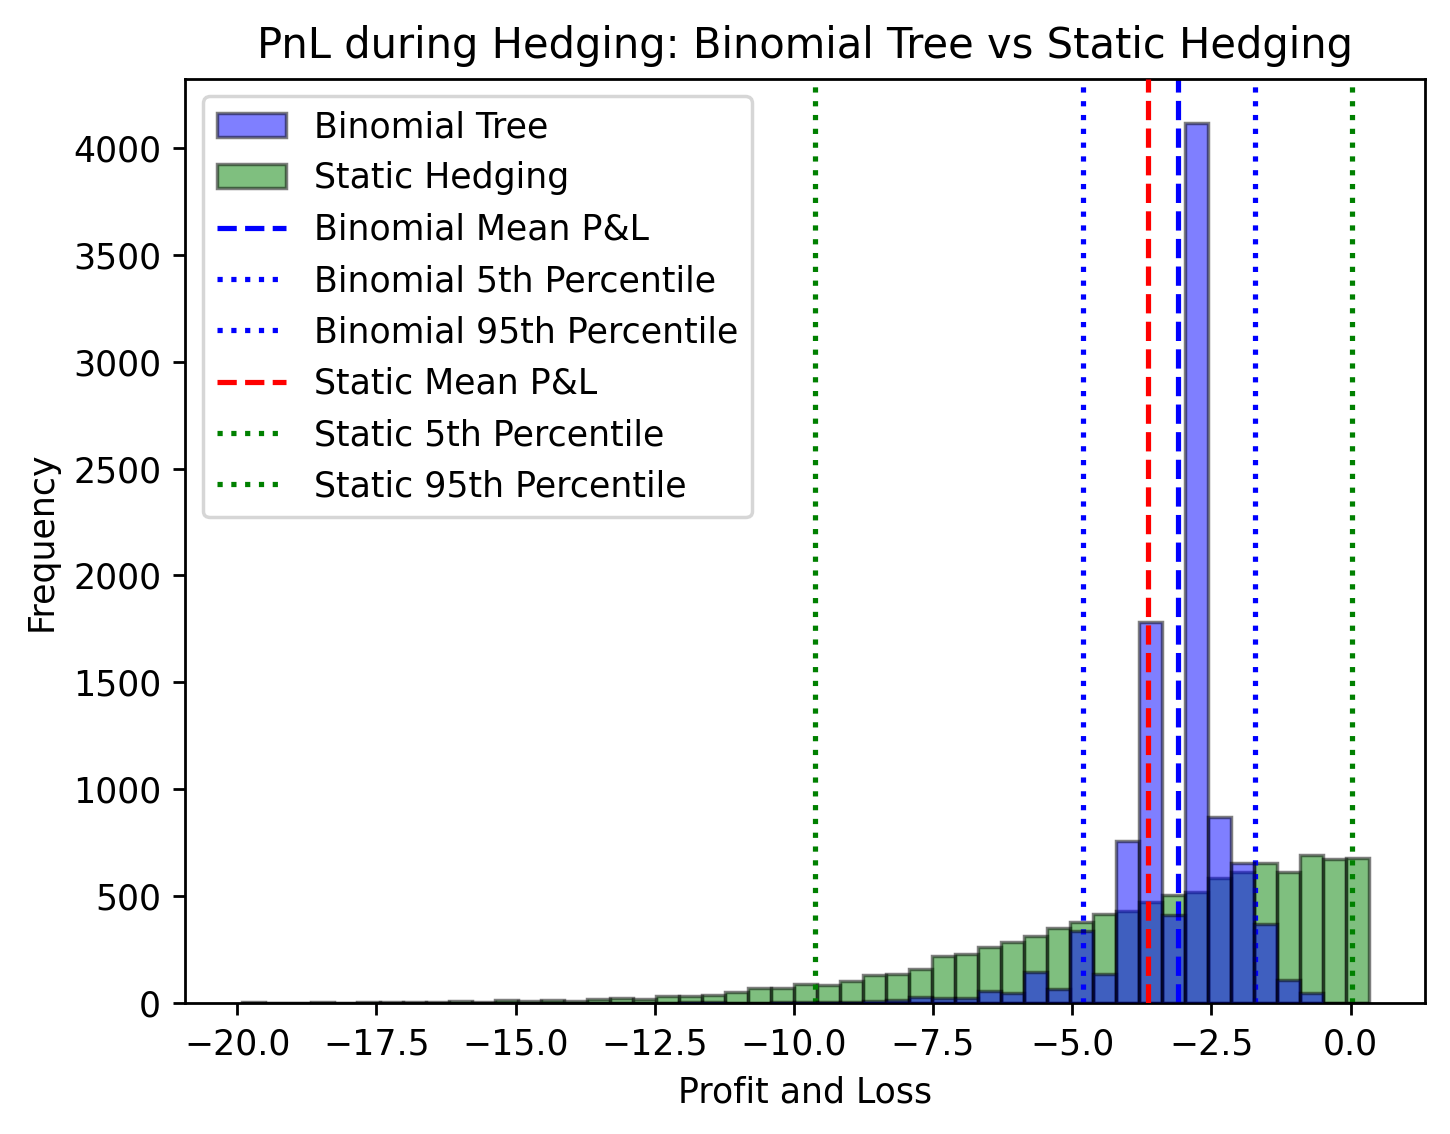

Binomial Tree - Mean P&L: -3.0994, 5th Percentile: -4.8077, 95th Percentile: -1.7157
Static Hedging - Mean P&L: -3.6313, 5th Percentile: -9.6176, 95th Percentile: 0.0256


In [ ]:
def build_binomial_tree_with_deltas(S0, K, T, r, sigma, N, exercise_dates, option_type="put"):
    """
    Builds a binomial tree for stock prices, option values, and deltas for Bermudan options.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))
    delta_tree = np.zeros((N, N))

    # Stock prices at maturity
    for i in range(N + 1):
        stock_tree[N, i] = S0 * (u ** (N - i)) * (d ** i)

    # Option values at maturity
    option_tree[N, :] = payoff_fun(stock_tree[N, :], K, option_type)

    # Convert exercise_dates to time steps
    exercise_steps = [int(e / dt + 0.5) for e in exercise_dates]

    # Backward induction for option values and deltas
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** (i - j)) * (d ** j)
            continuation_value = np.exp(-r * dt) * (
                p * option_tree[i + 1, j] + (1 - p) * option_tree[i + 1, j + 1]
            )

            exercise_value = payoff_fun(stock_tree[i, j], K, option_type)

            if i in exercise_steps:
                option_tree[i, j] = max(continuation_value, exercise_value)
            else:
                option_tree[i, j] = continuation_value

            # Delta calculation
            delta_tree[i, j] = (
                option_tree[i + 1, j] - option_tree[i + 1, j + 1]
            ) / (stock_tree[i + 1, j] - stock_tree[i + 1, j + 1])

    return stock_tree, option_tree, delta_tree

def bermudan_option_price_binomial(S0, K, T, r, sigma, N, exercise_dates, option_type="put"):
    """
    Computes the Bermudan option price using a binomial tree starting from S0 with time T.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))

    # Stock prices at maturity
    for i in range(N + 1):
        stock_tree[N, i] = S0 * (u ** (N - i)) * (d ** i)

    # Option values at maturity
    option_tree[N, :] = payoff_fun(stock_tree[N, :], K, option_type)

    # Convert exercise_dates to time steps
    exercise_steps = [int(e / dt + 0.5) for e in exercise_dates]

    # Backward induction for option values
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** (i - j)) * (d ** j)
            continuation_value = np.exp(-r * dt) * (
                p * option_tree[i + 1, j] + (1 - p) * option_tree[i + 1, j + 1]
            )

            exercise_value = payoff_fun(stock_tree[i, j], K, option_type)

            if i in exercise_steps:
                option_tree[i, j] = max(continuation_value, exercise_value)
            else:
                option_tree[i, j] = continuation_value

    return option_tree[0, 0]

def static_hedging_experiment_PnL(S0, K, T, t, r, sigma, num_simulations=1000, option_type="call", no_hidden_units=16, exercise_dates=None):
    """
    Performs a static hedging P&L experiment using neural networks adjusted for Bermudan options.
    Uses binomial Bermudan pricer to compute option prices at time t.
    """
    N = int(T * 252)  # Assuming daily steps
    dt = T / N
    stock_paths = stock_price_simulator(S0, r, sigma, T, N, num_simulations)
    
    # At time t, get stock prices
    idx_t = int(t / T * N)
    stock_prices_t = stock_paths[:, idx_t]
    
    # For each stock price at time t, compute the Bermudan option price using binomial tree
    T_remaining = T - t
    N_tree = 50  # Number of steps in the binomial tree for remaining time

       # Adjust exercise dates to reflect the time remaining from t to maturity
    # -------------------------------------------------------------------------------------
    # The original exercise dates provided correspond to the full option lifespan [0, T].
    # However, when pricing the Bermudan option at time t (a point within the option's life),
    # only exercise opportunities occurring after t are relevant. The exercise dates are
    # therefore adjusted to a new timeline starting at t and spanning the remaining time
    # horizon [t, T]. 
    # 
    # This adjustment serves two purposes:
    # 1. It excludes past exercise dates (i.e., dates < t), as they are no longer available.
    # 2. It shifts the remaining exercise dates to a relative time scale by subtracting t
    #    from each, ensuring they align with the reduced time horizon [0, T_remaining].
    # 
    # Example:
    # - Original exercise dates: [0.25, 0.5, 0.75, 1.0] years
    # - Current time: t = 0.5 years
    # - Adjusted exercise dates: [0.25, 0.5] years (remaining times from t to [0.75, 1.0])

    adjusted_exercise_dates = [e - t for e in exercise_dates if e >= t]
    
    option_prices_t = np.zeros(num_simulations)
    for i in range(num_simulations):
        S_t = stock_prices_t[i]
        # Compute the option price starting from S_t
        option_price = bermudan_option_price_binomial(
            S_t, K, T_remaining, r, sigma, N_tree, adjusted_exercise_dates, option_type
        )
        option_prices_t[i] = option_price
    
    # Train neural network to approximate option prices at time t
    X_train = stock_prices_t.reshape(-1, 1)
    y_train = option_prices_t.reshape(-1, 1)
    
    # Normalize inputs and outputs
    normalizer = S0
    X_train_normalized = X_train / normalizer
    y_train_normalized = y_train / normalizer
    
    # Create and train neural network
    model = create_shallow_NN(1, no_hidden_units)
    
    optimizer = Adam(0.05)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    early_stopping = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
    model.fit(
        X_train_normalized,
        y_train_normalized,
        epochs=3000,
        batch_size=128,
        callbacks=[early_stopping],
        verbose=0,
    )
    
    # Extract neural network parameters to construct static hedging portfolio
    weights = model.get_weights()
    W1 = weights[0]
    b1 = weights[1]
    W2 = weights[2]
    b2 = weights[3]
    
    inner_wts = W1[0, :]
    nn_strikes = b1
    outer_wts = W2[:, 0]
    outer_bias = b2[0]
    
    # Identify positions
    positions = np.where(
        np.logical_and(inner_wts > 0, nn_strikes < 0),
        "C",
        np.where(
            np.logical_and(inner_wts > 0, nn_strikes >= 0),
            "F",
            np.where(
                np.logical_and(inner_wts < 0, nn_strikes > 0),
                "P",
                "N",
            ),
        ),
    )
    
    # Find instrument parameters
    strikes_array = np.where(
        positions == "F",
        -S0 * np.abs(nn_strikes) / np.abs(inner_wts),
        S0 * np.abs(nn_strikes) / np.abs(inner_wts),
    )
    
    # Deposit is outer_bias * S0
    deposit = outer_bias * S0
    
    # Portfolio weights
    pfl_weights = np.abs(inner_wts) * outer_wts
    
    # Compute initial cost of setting up the static hedge
    c_wt = pfl_weights * (positions == "C")
    p_wt = pfl_weights * (positions == "P")
    f_wt = pfl_weights * (positions == "F")
    
    non_neg_strks = np.abs(strikes_array)
    
    # Use Black-Scholes formula to price the hedging instruments
    # For the static hedge, European options are used, so we can use Black-Scholes
    pv_calls = c_wt * bs_option_price(S0, non_neg_strks, t, r, sigma, option_type="call")
    pv_puts = p_wt * bs_option_price(S0, non_neg_strks, t, r, sigma, option_type="put")
    pv_fwds = f_wt * (S0 - strikes_array) * np.exp(-r * t)
    
    initial_cost = np.sum(pv_calls + pv_puts + pv_fwds) + deposit * np.exp(-r * t)
    
    # At time T, compute the final value of the static hedging portfolio
    stock_prices_T = stock_paths[:, -1]
    
    # Compute the payoff of the static hedge portfolio at time T
    strks = strikes_array.reshape(1, -1)
    non_neg_strks = np.abs(strks)
    wts = pfl_weights.reshape(1, -1)
    pos = positions.reshape(1, -1)

    c_wt = wts * (pos == "C")
    p_wt = wts * (pos == "P")
    f_wt = wts * (pos == "F")

    stock_vec = stock_prices_T.reshape(-1, 1)

    hedge_payoff = (
        np.sum(
            c_wt * np.maximum(stock_vec - non_neg_strks, 0)
            + p_wt * np.maximum(non_neg_strks - stock_vec, 0)
            + f_wt * (stock_vec - strks),
            axis=1,
        )
        + deposit
    )
    
    # Compute the option payoff at time T
    option_payoff_T = payoff_fun(stock_prices_T, K, option_type)
    
    # Compute the P&L
    PnL = hedge_payoff - option_payoff_T - initial_cost
    
    return PnL

def delta_hedging_experiment_binomial_tree(
    S0, K, T, r, sigma, N, exercise_dates, option_type="put", num_simulations=10000
):
    """
    Performs a delta hedging experiment using stock prices and deltas from the binomial tree for Bermudan options.
    """
    # Build the binomial tree and compute deltas
    stock_tree, option_tree, delta_tree = build_binomial_tree_with_deltas(
        S0, K, T, r, sigma, N, exercise_dates, option_type
    )

    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    total_cost = []
    pay_received = []

    for path_idx in range(num_simulations):
        prev_delta = 0
        cost = 0
        path = []
        indices = []
        j = 0  # Start at the root of the tree
        for t_idx in range(N):
            # Simulate move: up with probability p, down with probability 1 - p
            if np.random.rand() < p:
                # Up move: index j stays the same
                pass
            else:
                # Down move: increase index j by 1
                j += 1
            indices.append(j)
            S = stock_tree[t_idx, j]
            path.append(S)

            current_delta = delta_tree[t_idx, j]
            # Adjust portfolio
            delta_diff = current_delta - prev_delta
            cost -= delta_diff * S * np.exp(-r * t_idx * dt)
            prev_delta = current_delta

        # Option payoff at maturity
        final_S = stock_tree[N, j]
        payoff = payoff_fun(final_S, K, option_type)

        # Final adjustment for delta position
        cost += prev_delta * final_S * np.exp(-r * T)
        total_cost.append(cost)
        pay_received.append(-payoff * np.exp(-r * T))  # Discounted option payoff

    # Calculate P&L
    final_PnL = np.array(total_cost) + np.array(pay_received)
    return final_PnL


# Parameters
S0 = 50
K = 50
T = 1
t = 0.25  
r = 0.06
sigma = 0.2
N = 50
exercise_dates = [0.25, 0.5, 0.75, 1.0]
option_type = "put"
num_simulations = 10000
no_hidden_units = 16

# Run the binomial tree hedging experiment
PnL_binomial = delta_hedging_experiment_binomial_tree(
    S0, K, T, r, sigma, N, exercise_dates, option_type, num_simulations
)

# Run the static hedging experiment
PnL_static = static_hedging_experiment_PnL(
    S0, K, T, t, r, sigma, num_simulations, option_type, no_hidden_units, exercise_dates
)

# Calculate statistics
mean_PnL_binomial = np.mean(PnL_binomial)
PnL_binomial_5 = np.percentile(PnL_binomial, 5)
PnL_binomial_95 = np.percentile(PnL_binomial, 95)

mean_PnL_static = np.mean(PnL_static)
PnL_static_5 = np.percentile(PnL_static, 5)
PnL_static_95 = np.percentile(PnL_static, 95)

# Plotting
fig, ax = plt.subplots(dpi=250)

bins = np.linspace(min(np.min(PnL_binomial), np.min(PnL_static)), max(np.max(PnL_binomial), np.max(PnL_static)), 50)

ax.hist(PnL_binomial, bins=bins, alpha=0.5, label="Binomial Tree", edgecolor="black", color="blue", zorder=99)
ax.hist(PnL_static, bins=bins, alpha=0.5, label="Static Hedging", edgecolor="black", color="green")

# Plot mean and percentiles for Binomial
ax.axvline(x=mean_PnL_binomial, color="blue", linestyle="--", label="Binomial Mean P&L")
ax.axvline(x=PnL_binomial_5, color="blue", linestyle=":", label="Binomial 5th Percentile")
ax.axvline(x=PnL_binomial_95, color="blue", linestyle=":", label="Binomial 95th Percentile")

# Plot mean and percentiles for Static Hedging
ax.axvline(x=mean_PnL_static, color="red", linestyle="--", label="Static Mean P&L", zorder=100)
ax.axvline(x=PnL_static_5, color="green", linestyle=":", label="Static 5th Percentile")
ax.axvline(x=PnL_static_95, color="green", linestyle=":", label="Static 95th Percentile")

ax.set_xlabel("Profit and Loss")
ax.set_ylabel("Frequency")
ax.legend()
plt.title("PnL during Hedging: Binomial Tree vs Static Hedging")
plt.show()

print(f"Binomial Tree - Mean P&L: {mean_PnL_binomial:.4f}, "
      f"5th Percentile: {PnL_binomial_5:.4f}, 95th Percentile: {PnL_binomial_95:.4f}")
print(f"Static Hedging - Mean P&L: {mean_PnL_static:.4f}, "
      f"5th Percentile: {PnL_static_5:.4f}, 95th Percentile: {PnL_static_95:.4f}")


In [4]:
sigma_values = [0.05, 0.10, 0.20]

results = {}

for sigma in sigma_values:
    # Run the binomial tree hedging experiment
    PnL_binomial = delta_hedging_experiment_binomial_tree(
    S0, K, T, r, sigma, N, exercise_dates, option_type, num_simulations
)
    # Run the static hedging experiment
    PnL_static = static_hedging_experiment_PnL(
    S0, K, T, t, r, sigma, num_simulations, option_type, no_hidden_units, exercise_dates
)
    
    # Calculate statistics
    mean_PnL_binomial = np.mean(PnL_binomial)
    PnL_binomial_5 = np.percentile(PnL_binomial, 5)
    PnL_binomial_95 = np.percentile(PnL_binomial, 95)
    
    mean_PnL_static = np.mean(PnL_static)
    PnL_static_5 = np.percentile(PnL_static, 5)
    PnL_static_95 = np.percentile(PnL_static, 95)
    
    # Store results
    results[sigma] = {
        'PnL_binomial': PnL_binomial,
        'PnL_static': PnL_static,
        'mean_PnL_binomial': mean_PnL_binomial,
        'PnL_binomial_5': PnL_binomial_5,
        'PnL_binomial_95': PnL_binomial_95,
        'mean_PnL_static': mean_PnL_static,
        'PnL_static_5': PnL_static_5,
        'PnL_static_95': PnL_static_95,
    }

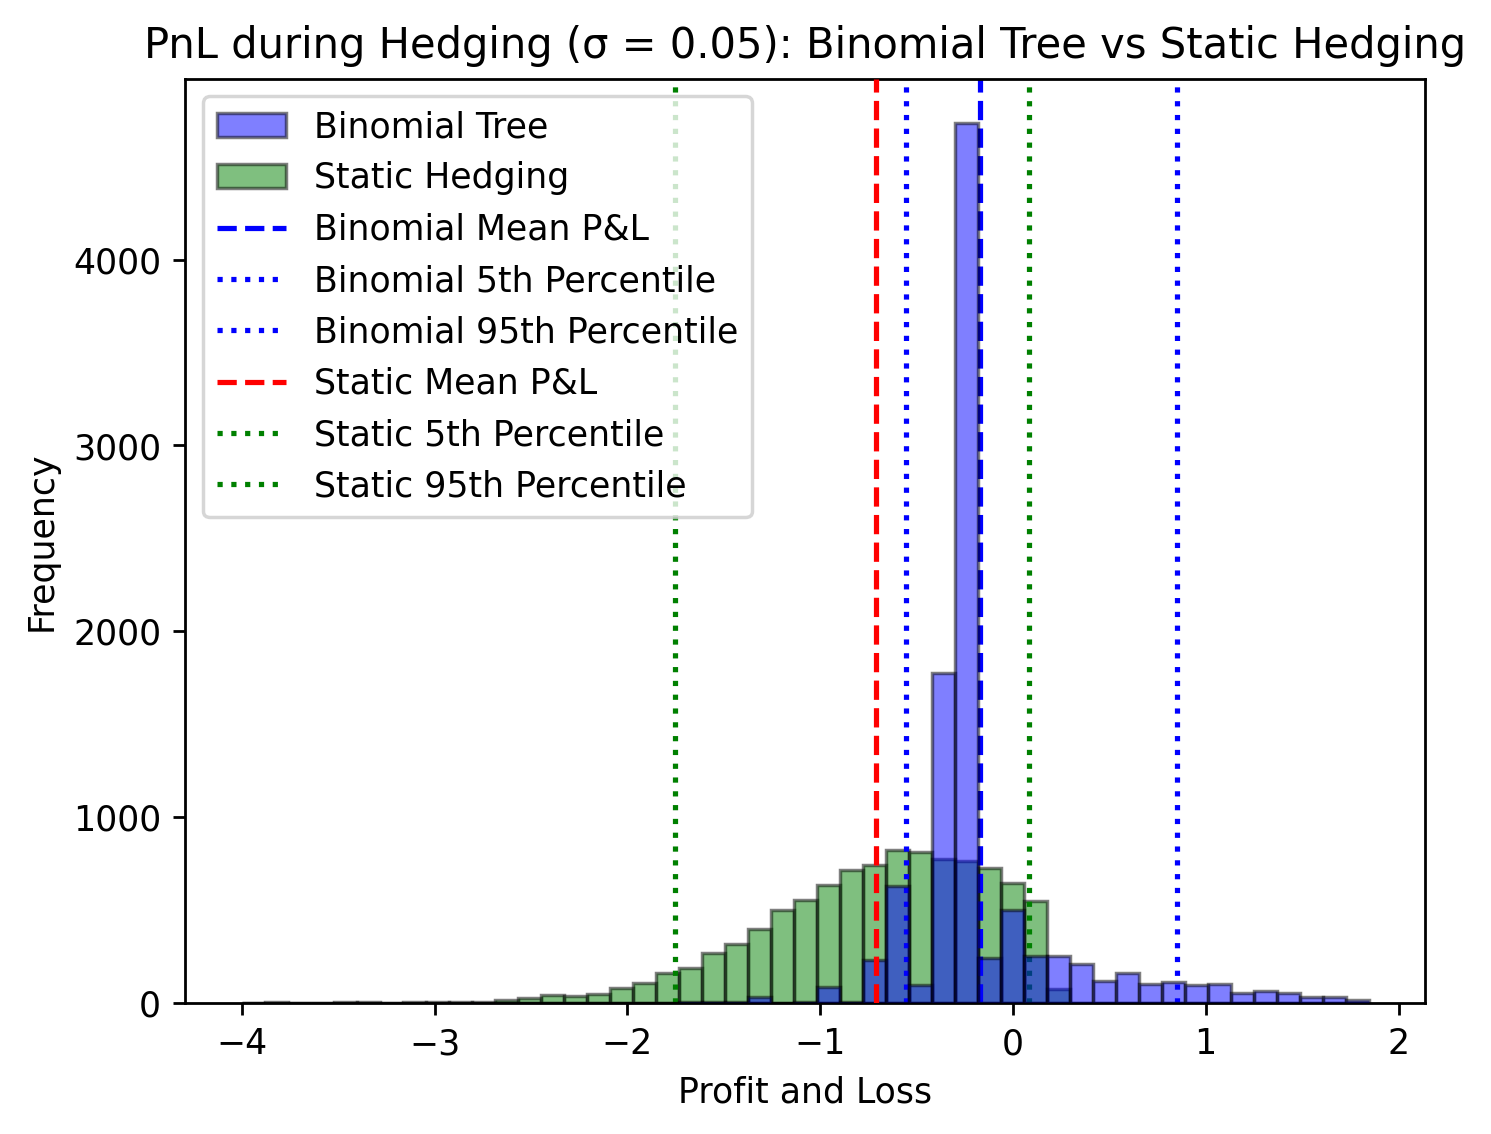

Binomial Tree - Mean P&L: -0.1726, 5th Percentile: -0.5527, 95th Percentile: 0.8518
Static Hedging - Mean P&L: -0.7104, 5th Percentile: -1.7554, 95th Percentile: 0.0825


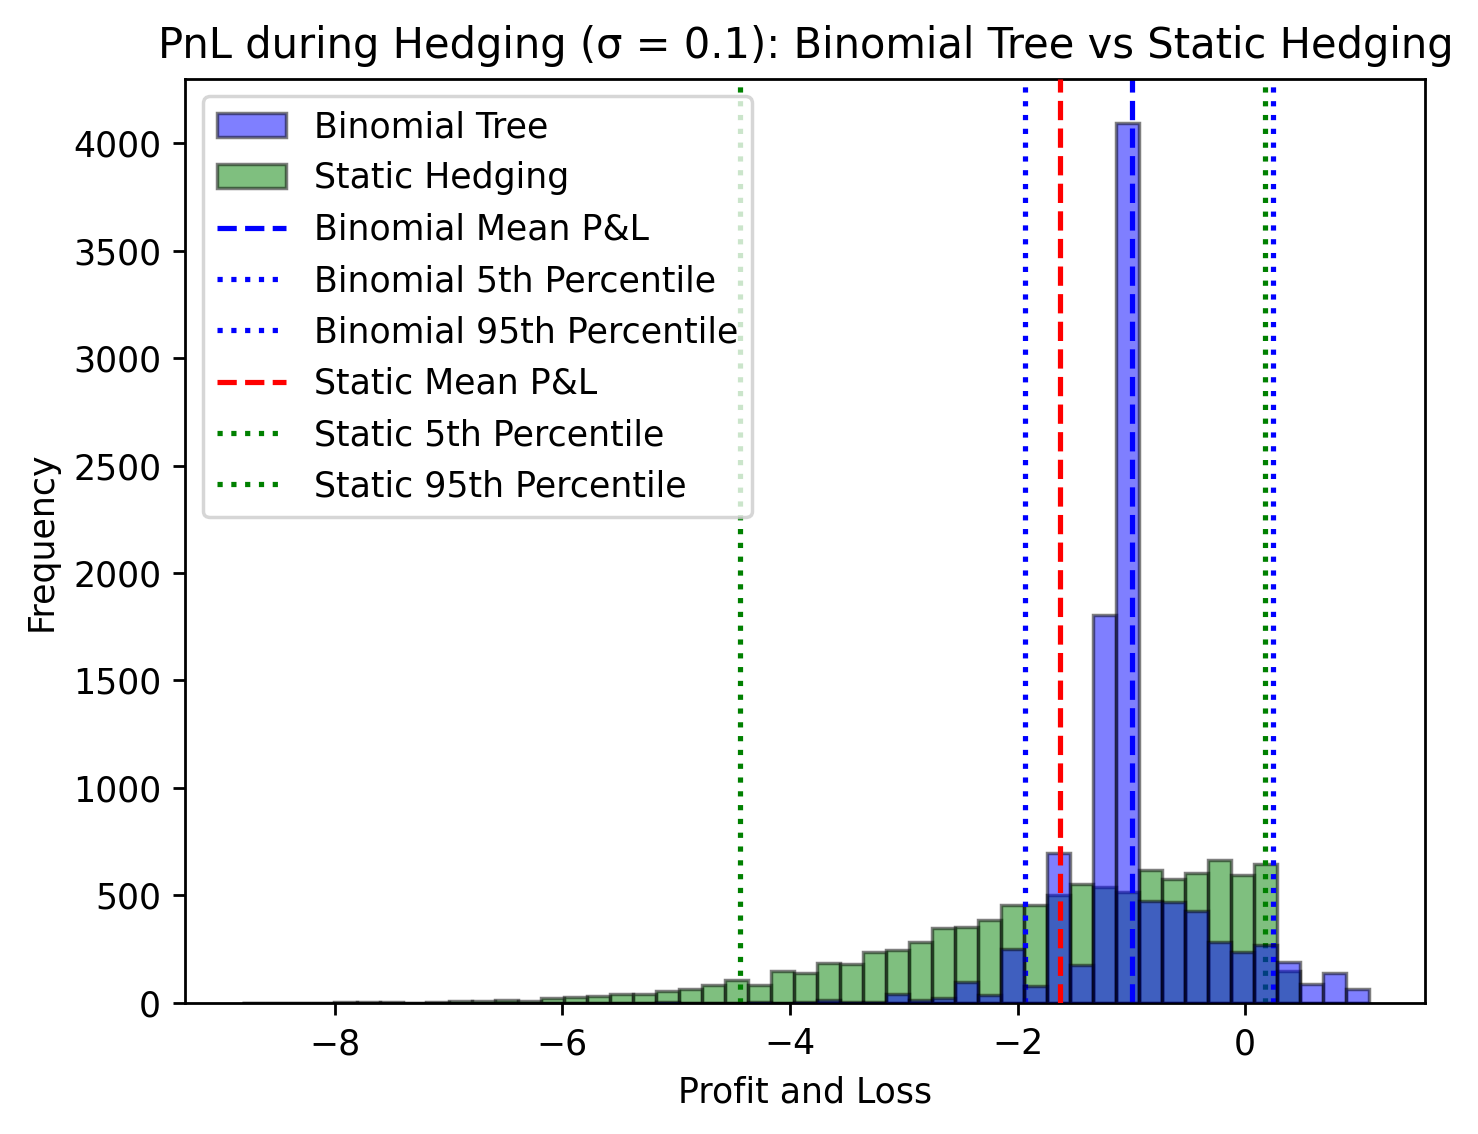

Binomial Tree - Mean P&L: -0.9968, 5th Percentile: -1.9377, 95th Percentile: 0.2475
Static Hedging - Mean P&L: -1.6290, 5th Percentile: -4.4391, 95th Percentile: 0.1705


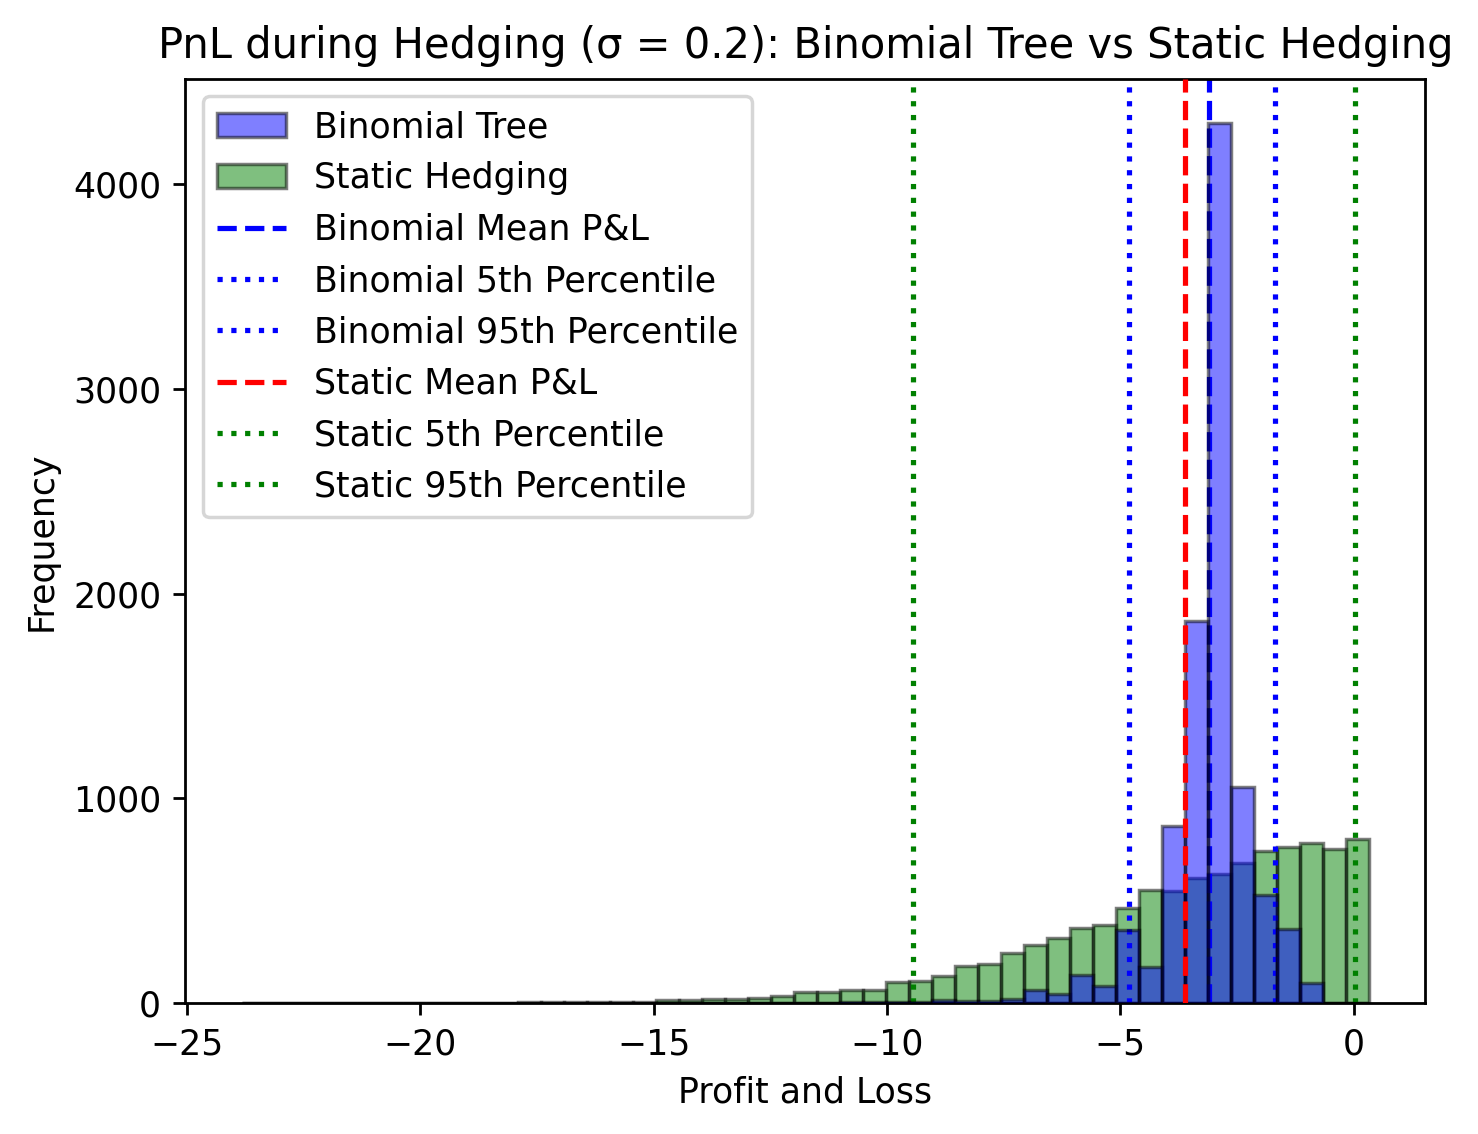

Binomial Tree - Mean P&L: -3.1005, 5th Percentile: -4.8077, 95th Percentile: -1.6903
Static Hedging - Mean P&L: -3.6188, 5th Percentile: -9.4513, 95th Percentile: 0.0264


In [6]:
for sigma in sigma_values:
    data = results[sigma]
    
    PnL_binomial = data['PnL_binomial']
    PnL_static = data['PnL_static']
    mean_PnL_binomial = data['mean_PnL_binomial']
    PnL_binomial_5 = data['PnL_binomial_5']
    PnL_binomial_95 = data['PnL_binomial_95']
    mean_PnL_static = data['mean_PnL_static']
    PnL_static_5 = data['PnL_static_5']
    PnL_static_95 = data['PnL_static_95']
    
    # Plotting
    fig, ax = plt.subplots(dpi=250)
    
    bins = np.linspace(
        min(np.min(PnL_binomial), np.min(PnL_static)),
        max(np.max(PnL_binomial), np.max(PnL_static)), 50
    )
    
    ax.hist(PnL_binomial, bins=bins, alpha=0.5, label="Binomial Tree",
            edgecolor="black", color="blue", zorder=99)
    
    ax.hist(PnL_static, bins=bins, alpha=0.5, label="Static Hedging",
            edgecolor="black", color="green")
    
    # Plot mean and percentiles for Binomial
    ax.axvline(x=mean_PnL_binomial, color="blue", linestyle="--", label="Binomial Mean P&L")
    ax.axvline(x=PnL_binomial_5, color="blue", linestyle=":", label="Binomial 5th Percentile")
    ax.axvline(x=PnL_binomial_95, color="blue", linestyle=":", label="Binomial 95th Percentile")
    
    # Plot mean and percentiles for Static Hedging
    ax.axvline(x=mean_PnL_static, color="red", linestyle="--", label="Static Mean P&L", zorder=100)
    ax.axvline(x=PnL_static_5, color="green", linestyle=":", label="Static 5th Percentile")
    ax.axvline(x=PnL_static_95, color="green", linestyle=":", label="Static 95th Percentile")
    
    ax.set_xlabel("Profit and Loss")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.title(f"PnL during Hedging (σ = {sigma}): Binomial Tree vs Static Hedging")
    plt.show()
    print(f"Binomial Tree - Mean P&L: {mean_PnL_binomial:.4f}, "
        f"5th Percentile: {PnL_binomial_5:.4f}, 95th Percentile: {PnL_binomial_95:.4f}")
    print(f"Static Hedging - Mean P&L: {mean_PnL_static:.4f}, "
        f"5th Percentile: {PnL_static_5:.4f}, 95th Percentile: {PnL_static_95:.4f}")
